<a href="https://colab.research.google.com/github/sidhu2690/IDC-409/blob/main/DS_409_Facial_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
from torch.nn.functional import cosine_similarity

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class UnlabelledFaceDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

unlabelled_data_path = '/kaggle/input/50k-celebrity-faces-image-dataset/Celebrity_Faces_Dataset'
unlabelled_dataset = UnlabelledFaceDataset(unlabelled_data_path, transform=transform)
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=32, shuffle=True)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

epochs = 10
train_loss_history = []

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    for images in unlabelled_loader:
        images = images.to(device)

        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(unlabelled_loader)
    train_loss_history.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

print("DonE aNd DusTeD")

Epoch [1/10], Loss: 0.0175
Epoch [2/10], Loss: 0.0051
Epoch [3/10], Loss: 0.0035
Epoch [4/10], Loss: 0.0028
Epoch [5/10], Loss: 0.0023
Epoch [6/10], Loss: 0.0020
Epoch [7/10], Loss: 0.0018
Epoch [8/10], Loss: 0.0016
Epoch [9/10], Loss: 0.0014
Epoch [10/10], Loss: 0.0013
DonE aNd DusTeD


In [ ]:
model_path = "autoencoder_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(autoencoder.state_dict(), f)

print("Saving DonE!!!")

Saving DonE!!!


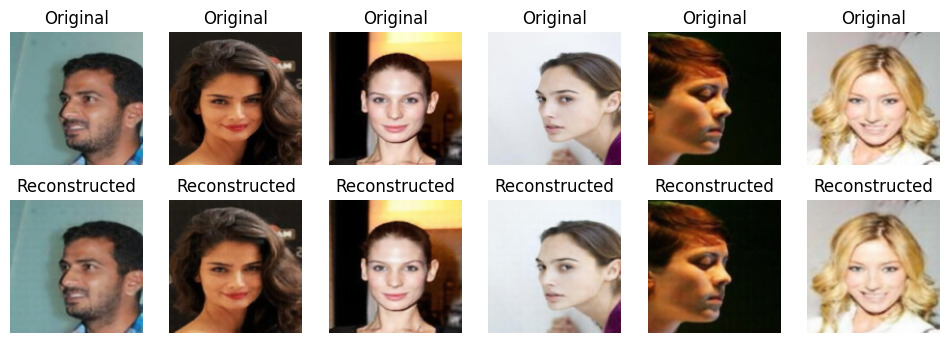

In [ ]:
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    return tensor

dataiter = iter(unlabelled_loader)
images = next(dataiter)
images = images.to(device)

autoencoder.eval()
with torch.no_grad():
    reconstructed = autoencoder(images)

images = images.cpu()
reconstructed = reconstructed.cpu()

n_images = 6
plt.figure(figsize=(12, 4))

for i in range(n_images):
    plt.subplot(2, n_images, i + 1)
    plt.imshow(np.transpose(denormalize(images[i]).numpy(), (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(np.transpose(denormalize(reconstructed[i]).numpy(), (1, 2, 0)))
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

In [ ]:
index = 9

original_flat = images[index].view(-1)
reconstructed_flat = reconstructed[index].view(-1)

cosine_similarity_value = cosine_similarity(original_flat, reconstructed_flat, dim=0)
print(f"Cosine Similarity for image {index + 1}: {cosine_similarity_value.item():.4f}")

Cosine Similarity for image 10: 0.9979


In [ ]:
class LabeledFaceDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.classes = os.listdir(root_folder)
        self.image_paths = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_folder, class_name)
            for img in os.listdir(class_folder):
                self.image_paths.append(os.path.join(class_folder, img))
                self.labels.append(idx)

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data_path = '/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset'
train_dataset = LabeledFaceDataset(train_data_path, transform=transform)

In [ ]:
dataset_size = len(train_dataset)
subset_size = int(1 * dataset_size)
subset_indices = np.random.choice(dataset_size, subset_size, replace=False)
train_subset = Subset(train_dataset, subset_indices)
train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True)

In [ ]:
# classifier model
class FaceRecognitionModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FaceRecognitionModel, self).__init__()

        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(512 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

trained_autoencoder = autoencoder
encoder = trained_autoencoder.encoder
num_classes = len(os.listdir(train_data_path))
model = FaceRecognitionModel(encoder, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()

    for images, labels in train_loader_subset:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader_subset):.4f}, Accuracy: {accuracy:.2f}%')

print("DonE AND DustEd")

Epoch [1/20], Loss: 5.9238, Accuracy: 13.67%
Epoch [2/20], Loss: 2.4957, Accuracy: 35.67%
Epoch [3/20], Loss: 2.0301, Accuracy: 46.61%
Epoch [4/20], Loss: 1.7010, Accuracy: 54.22%
Epoch [5/20], Loss: 1.0197, Accuracy: 70.44%
Epoch [6/20], Loss: 0.6043, Accuracy: 82.39%
Epoch [7/20], Loss: 0.5348, Accuracy: 84.00%
Epoch [8/20], Loss: 0.5307, Accuracy: 84.83%
Epoch [9/20], Loss: 0.2389, Accuracy: 94.06%
Epoch [10/20], Loss: 0.2090, Accuracy: 95.06%
Epoch [11/20], Loss: 0.1202, Accuracy: 98.33%
Epoch [12/20], Loss: 0.0625, Accuracy: 99.83%
Epoch [13/20], Loss: 0.0419, Accuracy: 100.00%
Epoch [14/20], Loss: 0.0378, Accuracy: 100.00%
Epoch [15/20], Loss: 0.0330, Accuracy: 100.00%
Epoch [16/20], Loss: 0.0295, Accuracy: 100.00%
Epoch [17/20], Loss: 0.0255, Accuracy: 100.00%
Epoch [18/20], Loss: 0.0239, Accuracy: 100.00%
Epoch [19/20], Loss: 0.0214, Accuracy: 100.00%
Epoch [20/20], Loss: 0.0209, Accuracy: 100.00%
DonE AND DustEd


In [ ]:
path = 'face_recognition_model.pkl'
torch.save(model.state_dict(), path)
print(f'Done!!!')

Done!!!


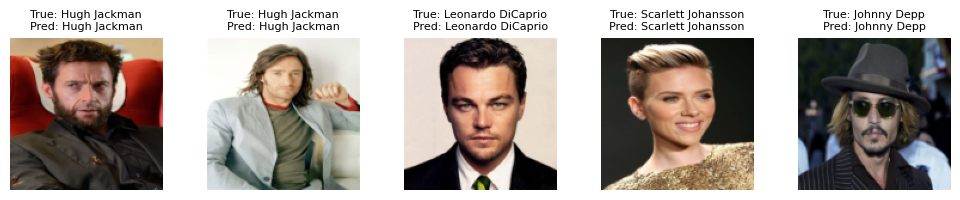

In [ ]:
def imshow_compact(image, title, ax):
    image = image / 2 + 0.5
    npimg = image.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(title, fontsize=8)
    ax.axis('off')

def test_random_images_compact(model, dataset, class_names, device, num_images=5):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))

    with torch.no_grad():
        for i in range(num_images):
            idx = random.randint(0, len(dataset) - 1)
            image, true_label = dataset[idx]

            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            _, predicted_label = torch.max(output, 1)

            title = f"True: {class_names[true_label]}\nPred: {class_names[predicted_label.item()]}"
            imshow_compact(image.cpu(), title, axes[i])

    plt.tight_layout()
    plt.show()

class_names = os.listdir(train_data_path)
test_random_images_compact(model, train_dataset, class_names, device, num_images=5)

In [ ]:
import csv
from datetime import datetime
from PIL import Image
import torch
from torchvision import transforms

def predict_and_log_attendance(model, image_path, class_names, device, output_csv="attendance.csv"):

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted_label = torch.max(output, 1)
        predicted_name = class_names[predicted_label.item()]

    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    attendance_record = [predicted_name, timestamp]

    with open(output_csv, mode='a', newline='') as file:
        writer = csv.writer(file)

        if file.tell() == 0:
            writer.writerow(["Name", "Timestamp"])

        writer.writerow(attendance_record)

    print(f"Attendance for {predicted_name} logged to {output_csv} successfully.")

In [ ]:
class_names = os.listdir(train_data_path)
image_path = "/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset/Angelina Jolie/001_fe3347c0.jpg"
predict_and_log_attendance(model, image_path, class_names, device, output_csv="attendance.csv")

Attendance for Angelina Jolie logged to attendance.csv successfully.


In [ ]:
pd.read_csv("attendance.csv")

,Name,Timestamp
0,Angelina Jolie,2024-11-01 12:11:08
